In [ ]:
#Import necessary libraries
import sys
!{sys.executable} -m pip install numpy matplotlib scipy

# Imports and such
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Plotting and gif helper function 

#plot initial and final states
def plot_initial_final_solution(x, u0, u_final, title):
    plt.figure(figsize=(8, 4))
    plt.plot(x, u0, label="Initial", linestyle="--")
    plt.plot(x, u_final, label="Final", linewidth=2)
    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


# Animate solution 
def animate_solution(x, u_history, interval, title):
    fig, ax = plt.subplots(figsize=(8, 4))
    line, = ax.plot([], [], lw=2)
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(np.min(u_history), np.max(u_history))
    ax.set_xlabel("x")
    ax.set_ylabel("u(x)")
    ax.set_title(title)
    ax.grid(True)

    def init():
        line.set_data([], [])
        return (line,)

    def update(frame):
        line.set_data(x, u_history[frame])
        return (line,)

    ani = FuncAnimation(fig, update, frames=len(u_history),
                        init_func=init, blit=True, interval=interval)

    plt.close(fig)
    return ani

# to save as gif: ani.save("mygif.gif", writer="pillow")


In [3]:
# Additional helper functions 
def initialize_domain(x_min, x_max, nx, T, cfl, v, custom_dt):
    """
    Initialize spatial and temporal grids.

    Parameters:
    - x_min, x_max : float
        Domain endpoints in x.
    - nx            : int
        Number of grid points.
    - T             : float
        Final time.
    - cfl           : float, default=0.8
        Desired CFL number (ignored if custom_dt is provided).
    - v             : float, default=1.0
        Constant wave speed.
    - custom_dt     : float or None
        If given, use this Δt directly and recompute CFL as |v|·Δt/Δx.
        Otherwise compute Δt = cfl·Δx/|v|.

    Returns:
    - x   : 1D NumPy array of length nx
    - dx  : float
    - dt  : float (time step)
    - nt  : int   (number of steps = floor(T/Δt))
    - cfl : float (actual CFL = |v|·Δt/Δx)
    """
    x = np.linspace(x_min, x_max, nx, endpoint=False)
    dx = x[1] - x[0]

    if custom_dt is not None:
        dt = custom_dt
        cfl = abs(v) * dt / dx
    else:
        dt = cfl * dx / abs(v)

    nt = int(T / dt)
    return x, dx, dt, nt, cfl

def initial_condition_gaussian(x, center, width):
    return np.exp(-((x - center)**2) / (2 * width**2))

def initial_condition_square(x, center, width):
    return np.where(np.abs(x - center) < width / 2, 1.0, 0.0)

def compute_mass_over_time(u, dx):
    """
    Compute total mass at each time step: ∫ u(x) dx ≈ sum(u) * dx
    """
    return np.trapz(u, dx=dx, axis=1)


--------------------------------------------------------------------------------------------------------
Part 1: Finite Differences

Upwinding Scheme

In [ ]:
# Main solver code 
# Construct finite difference matrix
def construct_upwind_matrix(nx, dx, dt):
    """
    Construct the upwind matrix A for u_t = -u_x with periodic BCs.
    """
    lam = dt / dx
    main_diag = (1 - lam) * np.ones(nx)
    sub_diag = lam * np.ones(nx - 1)

    A = np.diag(main_diag) + np.diag(sub_diag, k=-1)
    # print(np.diag(main_diag)/(1-lam) + np.diag(sub_diag, k=-1)/lam)
    # Fix periodic wrap-around: bottom-left corner
    A[0, -1] = lam

    return A

#time stepping (Forward Euler)
def upwind_solver(u0, dx, dt, nt):
    """
    Matrix-based upwind solver that returns approximation at each time step.
    u[n] = approximate solution at time step n
    """
    nx = len(u0)
    A = construct_upwind_matrix(nx, dx, dt)

    u = np.zeros((nt + 1, nx))
    u[0] = u0.copy()

    for n in range(1, nt + 1):
        u[n] = A @ u[n - 1]

    return u


In [ ]:
## Solver call and plotting
#x_min, x_max, nx, T, cfl, v, custom_dt
#Set up domain
x, dx, dt, nt, cfl = initialize_domain(0,20, nx=200, T=15.0, cfl=0.8, v=1, custom_dt=None)

u0_gauss = initial_condition_gaussian(x,3,.5)
u0_square = initial_condition_square(x,3,2)

u_gauss = upwind_solver(u0_gauss, dx, dt, nt)
plot_initial_final_solution(x, u0_gauss, u_gauss[-1], "Guassian IC, (dt,dx)= ("+str(round(dt,4))+","+str(round(dx,4))+")")

In [ ]:
# Animate the solution
ani_gauss = animate_solution(x, u_gauss, interval=50, title="Upwind: Gaussian IC")

# Display inline in notebook
HTML(ani_gauss.to_jshtml())

Central Difference Scheme

In [ ]:
# Central difference Main Solve
def construct_central_diff_matrix(nx, dx, dt, v):
    """
    Construct central difference matrix for u_t + v u_x = 0 with periodic BCs.
    """
    lam = v * dt / dx
    main_diag = np.ones(nx)
    upper_diag = -0.5 * lam * np.ones(nx - 1)
    lower_diag =  0.5 * lam * np.ones(nx - 1)

    A = np.diag(main_diag)
    A += np.diag(lower_diag, k=-1)
    A += np.diag(upper_diag, k=1)
    A[0, -1] = 0.5 * lam
    A[-1, 0] = -0.5 * lam

    return A

def central_diff_solver(u0, v, dx, dt, nt):
    """
    Matrix-based central difference solver that returns approximation at each time step.
    u[n] = approximate solution at time step n
    """
    nx = len(u0)
    A = construct_central_diff_matrix(nx, dx, dt, v)

    u = np.zeros((nt + 1, nx))
    u[0] = u0.copy()

    for n in range(1, nt + 1):
        u[n] = A @ u[n - 1]

    return u


In [ ]:
#Central difference solver call and plotting

# x, dx, dt, nt, cfl = initialize_domain(0,20, nx=200, T=15.0, cfl=0.8, v=1, custom_dt=None)

# u0_gauss = initial_condition_gaussian(x,3,.5)
# u0_square = initial_condition_square(x,3,2)

u_gauss_central = central_diff_solver(u0_gauss, 1, dx, dt, nt)
plot_initial_final_solution(x, u0_gauss, u_gauss_central[-1], "(Central Diff) Guassian IC, (dt,dx)= ("+str(round(dt,4))+","+str(round(dx,4))+")")

Lax Wendroff Scheme

In [4]:
# Lax-Wendroff Main Solver code
def construct_lax_wendroff_matrix(nx, dx, dt, v):
    """
    Construct Lax–Wendroff matrix for u_t + v u_x = 0 with periodic BCs.
    """
    lam = v * dt / dx
    lam2 = lam**2

    main_diag  = (1 - lam2) * np.ones(nx)
    upper_diag = (-0.5 * lam + 0.5 * lam2) * np.ones(nx - 1)
    lower_diag = ( 0.5 * lam + 0.5 * lam2) * np.ones(nx - 1)

    A = np.diag(main_diag)
    A += np.diag(lower_diag, k=-1)
    A += np.diag(upper_diag, k=1)
    A[0, -1] =  0.5 * lam + 0.5 * lam2
    A[-1, 0] = -0.5 * lam + 0.5 * lam2

    return A

def lax_wendroff_solver(u0, v, dx, dt, nt):
    """
    Matrix-based Lax–Wendroff solver that returns approximation at each time step.
    u[n] = approximate solution at time step n
    """
    nx = len(u0)
    A = construct_lax_wendroff_matrix(nx, dx, dt, v)

    u = np.zeros((nt + 1, nx))
    u[0] = u0.copy()

    for n in range(1, nt + 1):
        u[n] = A @ u[n - 1]

    return u


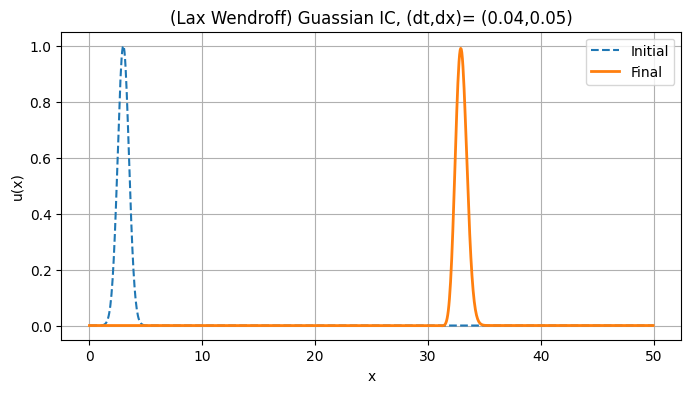

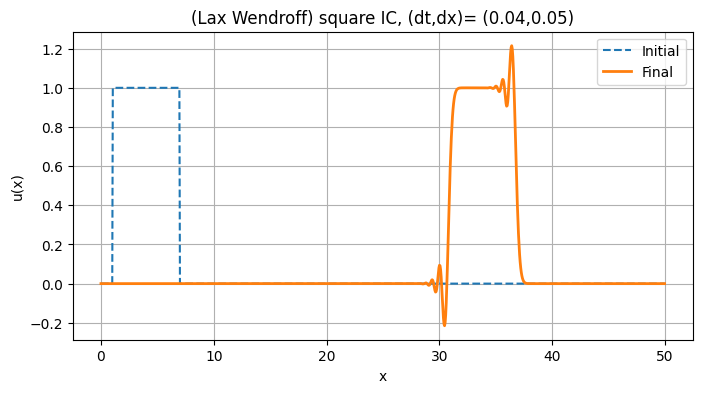

In [5]:
#Lax-Wendroff solver call and plotting
x, dx, dt, nt, cfl = initialize_domain(0,50, nx=1000, T=30.0, cfl=0.8, v=1, custom_dt=None)

u0_gauss = initial_condition_gaussian(x,3,.5)
u0_square = initial_condition_square(x,4,6)

u_gauss_lw = lax_wendroff_solver(u0_gauss, 1, dx, dt, nt)
u_square_lw = lax_wendroff_solver(u0_square, 1, dx, dt, nt)
plot_initial_final_solution(x, u0_gauss, u_gauss_lw[-1], "(Lax Wendroff) Guassian IC, (dt,dx)= ("+str(round(dt,4))+","+str(round(dx,4))+")")
plot_initial_final_solution(x, u0_square, u_square_lw[-1], "(Lax Wendroff) square IC, (dt,dx)= ("+str(round(dt,4))+","+str(round(dx,4))+")")

In [ ]:
# Animate the solution
ani_lw_gauss = animate_solution(x, u_gauss_lw, interval=40, title="Lax Wendroff: Gaussian IC")
HTML(ani_lw_gauss.to_jshtml())

--------------------------------------------------------------------------------------------------------
Part 2: Finite Volume Methods

In [ ]:
# Solution to Riemann problem for linear advection problem 
def riemann_linear(uL, uR, v):
    if v >= 0:
        return v * uL
    else:
        return v * uR
    
# Solution to Riemann Problem for Burger's Equation
def riemann_burgers(uL, uR):
    fL = 0.5 * uL**2
    fR = 0.5 * uR**2
    if uL <= uR:
        if uL >= 0:
            return fL
        elif uR <= 0:
            return fR
        else:
            return 0.0
    else:
        s = (fR - fL) / (uR - uL)
        return fL if s >= 0 else fR
    

In [ ]:
# Godunov solver for linear advection and Burgers' equation
# Numerical Flux calculation
def compute_interface_fluxes(u, riemann_solver, **kwargs):
    """
    u: array of cell averages, length nx
    returns F of length nx+1 (periodic)
    """
    nx = len(u)
    F = np.zeros(nx+1)
    for j in range(nx):
        uL = u[j]
        uR = u[(j+1) % nx]
        F[j+1] = riemann_solver(uL, uR, **kwargs)
    F[0] = F[nx]
    return F

def godunov_solver(u0, dx, dt, nt, riemann_solver, **kwargs):
    """
    u0: initial array (nx)
    dx, dt: steps
    nt: number of time steps
    riemann_solver: function(uL, uR, **kwargs)
    """
    nx = len(u0)
    u_hist = np.zeros((nt+1, nx))
    u_hist[0] = u0.copy()
    for n in range(nt):
        u = u_hist[n]
        F = compute_interface_fluxes(u, riemann_solver, **kwargs)
        u_new = np.empty_like(u)
        for j in range(nx):
            u_new[j] = u[j] - (dt/dx) * (F[j+1] - F[j])
        u_hist[n+1] = u_new
    return u_hist

In [ ]:
# Godunov solver call and plotting
# x, dx, dt, nt, cfl = initialize_domain(0,20, nx=200, T=15.0, cfl=0.8, v=1, custom_dt=None)

# u0_gauss = initial_condition_gaussian(x,3,.5)
# u0_square = initial_condition_square(x,3,2)

u_gauss_godunov = godunov_solver(u0_gauss, dx, dt, nt, riemann_linear,v=1)
plot_initial_final_solution(x, u0_gauss, u_gauss_godunov[-1], "(First Order Godunov) Guassian IC, (dt,dx)= ("+str(round(dt,4))+","+str(round(dx,4))+")")

In [ ]:
# Compare upwinding with Godounov (should be same)
u_gauss_up = upwind_solver(u0_gauss, dx, dt, nt)
plot_initial_final_solution(x, u_gauss_up[-1], u_gauss_godunov[-1], "(Upwind vs. Godunov) Guassian IC, (dt,dx)= ("+str(round(dt,4))+","+str(round(dx,4))+")")

Second order Godunov (Incomplete)

In [ ]:
#second order Godunov Solver <- under construction
# Piecewise-linear reconstruction for second order Godunov solver
def reconstruct_PL(u):
    """
    Piecewise-linear (second-order) reconstruction
    Given cell averages u[j], returns left and right states at each interface j+1/2:
      uL[i] = value at the right boundary of cell i
      uR[i] = value at the left boundary of cell i+1
    Periodic boundary conditions assumed.
    """
    # Compute central slope in each cell: (u[i+1] - u[i-1]) / 2
    slopes = 0.5 * (np.roll(u, -1) - np.roll(u, 1))
    
    # Left state at interface i+1/2 from cell i
    uL = u + 0.5 * slopes
    # Right state at interface i+1/2 from cell i+1
    uR = np.roll(u - 0.5 * slopes, -1)
    
    return uL, uR

def compute_fluxes_PL(u, riemann_solver, **kwargs):
    """
    Compute Godunov fluxes at all interfaces using
    piecewise-linear (unlimited) reconstruction.

    Parameters:
    - u: 1D array of cell-averages (length nx)
    - riemann_solver: function(uL, uR, **kwargs)
    - kwargs: extra args passed to riemann_solver (e.g. v)

    Returns:
    - F: 1D array of interface fluxes of length nx+1 (periodic)
    """
    # Reconstruct left/right states at each interface
    uL, uR = reconstruct_PL(u)
    nx = u.size

    # Compute mid-interface fluxes
    if riemann_solver is riemann_linear:
        v = kwargs['v']
        # Upwind on reconstructed states
        Fmid = np.where(v >= 0, v * uL, v * uR)
    else:
        # Burgers Godunov flux on reconstructed states
        fL = 0.5 * uL**2
        fR = 0.5 * uR**2
        rare = uL <= uR

        Fmid = np.empty_like(u)
        # Rarefaction cases
        Fmid[rare & (uL >= 0)] = fL[rare & (uL >= 0)]
        Fmid[rare & (uR <= 0)] = fR[rare & (uR <= 0)]
        Fmid[rare & (uL < 0) & (uR > 0)] = 0.0

        # Shock cases
        shock = ~rare
        s = (fR - fL) / (uR - uL)
        chooseL = shock & (s >= 0)
        chooseR = shock & (s < 0)
        Fmid[chooseL] = fL[chooseL]
        Fmid[chooseR] = fR[chooseR]

    # Pack into periodic interface array
    F = np.empty(nx+1, dtype=u.dtype)
    F[1:] = Fmid
    F[0]  = Fmid[-1]
    return F


MUSCL/Limiter Code

In [ ]:
# Flux‐Limiter Functions (phi)

def phi_minmod(r):
    """
    Minmod limiter: φ(r) = max(0, min(r, 1))
    """
    return np.maximum(0, np.minimum(r, 1.0))

def phi_vanleer(r):
    """
    Van Leer limiter: φ(r) = (r + |r|) / (1 + |r|)
    """
    return (r + np.abs(r)) / (1.0 + np.abs(r))

def phi_superbee(r):
    """
    Superbee limiter: φ(r) = max(0, min(2r,1), min(r,2))
    """
    return np.maximum(0, np.maximum(np.minimum(2.0*r, 1.0),
                                    np.minimum(r, 2.0)))


In [ ]:
# Flux limiter solver for advection
def flux_limiter_solver(u0, dx, dt, nt, phi_func):
    """
    Flux-limiter scheme with upwind + Lax-Wendroff blending.
    We use the known fluxes for this equation
    Parameters:
        u0       : Initial condition array
        dx       : Spatial step
        dt       : Time step
        nt       : Number of time steps
        phi_func : Limiter function φ(r)

    Returns:
        u_history : (nt+1, nx) array of solution at all time steps
    """
    u = u0.copy()
    nx = len(u)
    u_history = np.zeros((nt + 1, nx))
    u_history[0] = u0
    c = dt / dx  # assuming v = 1

    for n in range(1, nt + 1):
        u_next = u.copy()

        for i in range(2, nx - 1):
            du_i = u[i] - u[i - 1]
            du_im1 = u[i - 1] - u[i - 2]
            r = du_im1 / (du_i + 1e-12)
            phi_r = phi_func(r)

            F_lo = u[i - 1] #known upwind flux 
            F_hi = 0.5 * (u[i - 1] + u[i]) - 0.5 * c * (u[i] - u[i - 1]) #known lax-wendroff flux
            F_half = F_lo + phi_r * (F_hi - F_lo)

            du_ip1 = u[i + 1] - u[i]
            r_p1 = du_i / (du_ip1 + 1e-12)
            phi_r_p1 = phi_func(r_p1)
            F_lo_p1 = u[i]
            F_hi_p1 = 0.5 * (u[i] + u[i + 1]) - 0.5 * c * (u[i + 1] - u[i])
            F_half_p1 = F_lo_p1 + phi_r_p1 * (F_hi_p1 - F_lo_p1)

            u_next[i] = u[i] - c * (F_half_p1 - F_half)

        u = u_next.copy()
        u_history[n] = u

    return u_history


In [ ]:
# Example usage of flux limiter solver

# x, dx, dt, nt, cfl_actual = initialize_domain(x_min, 20, 400, 10, .8, 1, custom_dt   =None)
# u0_gauss = initial_condition_gaussian(x, center=2.5, width=0.5)
# u0_square = initial_condition_square(x, center=2.5, width=1)

u_minmod_gauss = flux_limiter_solver(u0_gauss, dx, dt, nt, phi_minmod)
plot_initial_final_solution(x, u0_gauss, u_minmod_gauss[-1], "Flux Limiter, minmod (dt,dx)= ("+str(round(dt,4))+","+str(round(dx,4))+")")
ani_minmod_gauss = animate_solution(x, u_minmod_gauss, 30,
                            " Minmod Flux Limiter: Gaussian IC, (dt,dx)= ("+str(round(dt,4))+","+str(round(dx,4))+")")
HTML(ani_minmod_gauss.to_jshtml())

In [ ]:
# Flux limiter solver for Burgers
def flux_limiter_solver_burgers(u0, dx, dt, nt, phi):
    """
    Flux limiter scheme for Burgers' equation: u_t + (1/2 u^2)_x = 0
    """
    nx = len(u0)
    u = np.zeros((nt + 1, nx))
    u[0] = u0.copy()

    for n in range(nt):
        un = u[n]

        # Compute physical flux: f = 1/2 * u^2
        f = 0.5 * un**2

        # Estimate wave speed at interfaces
        a = np.maximum(np.abs(un[:-1]), np.abs(un[1:]))

        # Compute low-order upwind flux
        f_lo = f[:-1]

        # Compute high-order Lax-Wendroff-like flux
        f_hi = 0.5 * (f[:-1] + f[1:]) - 0.5 * a * (un[1:] - un[:-1])

        # Compute r at i = 1 to nx-2 (interfaces 1.5 to nx-1.5)
        du = un[1:] - un[:-1]
        r = np.zeros_like(du)
        # Prevent divide by zero and set r=0 where both are small
        with np.errstate(divide='ignore', invalid='ignore'):
            r[1:] = (du[:-1] + 1e-8) / (du[1:] + 1e-8)

        # Apply limiter
        phi_r = phi(r)

        # Limited flux
        f_lim = f_lo + phi_r * (f_hi - f_lo)

        # Update: u[i] = u[i] - dt/dx * (F_{i+1/2} - F_{i-1/2})
        u[n+1, 1:-1] = un[1:-1] - dt / dx * (f_lim[1:] - f_lim[:-1])

        # Periodic BCs (you can change to zero Neumann/Dirichlet as needed)
        u[n+1, 0] = u[n+1, -2]
        u[n+1, -1] = u[n+1, 1]

    return u

In [ ]:
# Flux limiter solver for Burgers

# x, dx, dt, nt, cfl_actual = initialize_domain(0, 20, 400, 20, .8, 3, custom_dt=None)
# u0_gauss = initial_condition_gaussian(x, center=2.5, width=0.5)
# u0_square = initial_condition_square(x, center=4, width=3)

u_minmod_burgers = flux_limiter_solver_burgers(u0_gauss, dx, dt, nt, phi_minmod)
ani_minmod_burgers = animate_solution(x, u_minmod_burgers, 30,
                            " Minmod Flux Limiter for Burgers, (dt,dx)= ("+str(round(dt,4))+","+str(round(dx,4))+")")
HTML(ani_minmod_burgers.to_jshtml())
